In [19]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import urllib
import shutil
import os

In [22]:
# Download the collection from https://imgur.com/gallery/neLX1 as a zip file.
url = 'https://imgur.com/a/neLX1/zip'

if not os.path.exists('neLX1.zip'):
    request = urllib.request.urlopen(url)
    
    with open('neLX1.zip', 'wb') as f:
        shutil.copyfileobj(request, f)

print("neLX1.zip: {} bytes".format(os.path.getsize('neLX1.zip')))

neLX1.zip: 828700781 bytes


In [81]:
import zipfile
import subprocess
import shlex

zipfile = zipfile.ZipFile('neLX1.zip')
filenames = zipfile.namelist()

sizes = {}

print("{} GIFs to test".format(len(filenames)))

def transcode_and_report_sizes(filename):
    with zipfile.open(filename) as zf:
        with open(filename, 'wb') as f:
            shutil.copyfileobj(zf, f)
        
        webm_filename = "{}.webm".format(filename)
        
        # Transcode to webm
        cmd = "ffmpeg -i {} -c:v libvpx -vb 1k -crf 12 -pix_fmt yuv420p -f webm {}".format(shlex.quote(filename), shlex.quote(webm_filename))
        process = subprocess.run(shlex.split(cmd), capture_output=True)
        
        if process.returncode != 0:
            print("Could not transcode {}: {}".format(filename, process.stderr))
        else:
            print('.', end="")
            
        sizes[filename] = {}
        sizes[filename]['webm'] = os.path.getsize(webm_filename)
        os.remove(webm_filename)
        
        mp4_filename = "{}.mp4".format(filename)
            
        # Transcode to mp4
        cmd = "ffmpeg -i {} -c:v libx264 -crf 30 -movflags faststart -pix_fmt yuv420p -vf \"scale=trunc(iw/2)*2:trunc(ih/2)*2\" {}".format(shlex.quote(filename), shlex.quote(mp4_filename))
        process = subprocess.run(shlex.split(cmd), capture_output=True)
        
        if process.returncode != 0:
            print("Could not transcode {}: {}".format(filename, process.stderr))
        else:
            print('.', end="")
            
        sizes[filename]['h264'] = os.path.getsize(mp4_filename)
        os.remove(mp4_filename)
        os.remove(filename)
        
for filename in filenames:
    transcode_and_report_sizes(filename)

900 GIFs to test
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

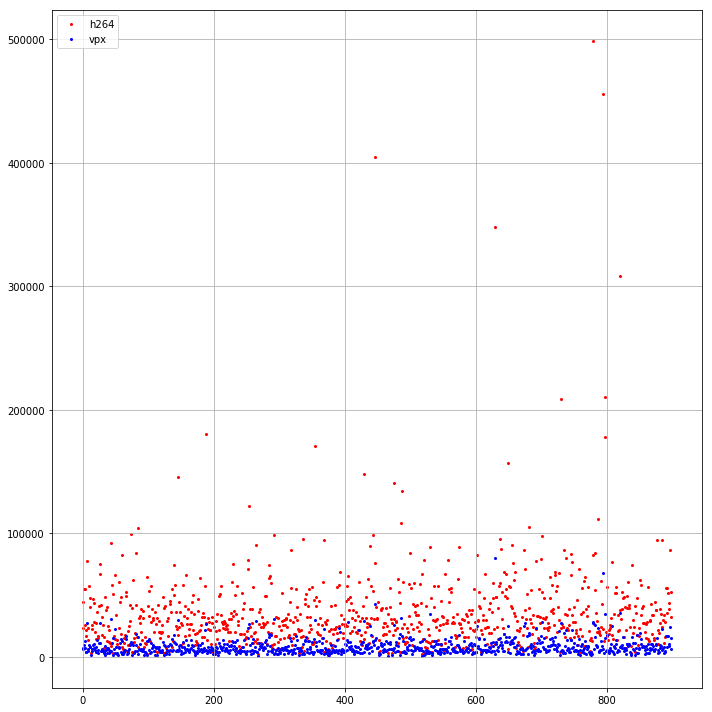

In [154]:
h264 = np.asarray(list(map(lambda filename: sizes[filename]['h264'], sizes)))
vpx = np.asarray(list(map(lambda filename: sizes[filename]['webm'], sizes)))

fig, ax = plt.subplots(figsize=(10, 10))

nums = np.arange(900)

ax.scatter(nums, h264, c='red', label='h264', s=4)
ax.scatter(nums, vpx, c='blue', label='vpx', s=4)
ax.grid(True)

fig.tight_layout()

plt.legend(loc=2)
plt.show()